In [3]:
from random import uniform
from dpi import *
import random


In [4]:
dp = Dilema(2, -1, 3, 0)

# Investigación de estrategia

## Exploración de algoritmo genético

Debido a la naturaleza de los torneos evolutivos, vamos a explorar la posibilidad de generar una estrategia mediante un algoritmo genético.


In [5]:
class Francisco(Agente):
    def __init__(self, dilema: Dilema, porcentaje):
        self.porcentaje = porcentaje
        super().__init__(dilema)

    def generar_decision(self):
        if len(self.resultados_partida.lista_dic) == 0:
            return 0

        if len(self.resultados_partida.lista_dic) % 3 == 0:
            return 1

        historial_oponente = self.resultados_partida.lista_jugadas_a2
        num_desertaciones = sum([1 for decision in historial_oponente if decision == 1])

        if num_desertaciones / len(self.resultados_partida.lista_dic) >= self.porcentaje:
            return 1
        else:
            return 0


paco = Francisco(dp, 0.3)

El primer paso que vamos a realizar es intentar parametrizar las estrategias del juego, de modo que, si encontramos valores adecuados para los parámetros, también encontraremos buenas estrategias para el juego. Nos planteamos los siguientes requisitos para una buena parametrización:

1. Las estrategias deben permitir reaccionar a las jugadas del rival (Reactividad).
2. Debe ser posible parametrizar estrategias simples como la de "TFT" (Tit for Tat). Esto, en el futuro, nos permitirá comprobar si el algoritmo acaba prefiriendo estas estrategias que ya conocemos.



La primera idea que hemos tenido para basar nuestra estrategia en parámetros es que dichos parámetros sean pesos que se multiplican por unas variables que encapsulan el estado de la partida, y que el resultado de la suma ponderada sirva para decidir si el agente coopera o deserta.

## $(\sum_{}^{}P_{i}C_{i}) + S = D$

$ -1 \le  P \le 1 $ peso: negativo tiende a desertar positivo a colaborar.  
$ 0 \le  C \le 1 $  caracteristica: dice cuanto se cumple una caracteristica en la partida.  
$ -1 \le  S \le 1 $  sesgo: sirve para hacer que la respuesta tienda a algo por defecto y marca la decisión de la primera ronda.  
$ D $ Decisión: Se interpreta viendo si es negativa -> C o positiva -> D.  


In [35]:
#Vamos a implementar un agente cuya estrategia queda definida por parámetros de este modo.

from numpy import dot

class Agente_parametros(Agente):
    def __init__(self, parametros:[float, ...], dilema:Dilema = dp):
        super().__init__(dilema)
        self.parametros = parametros  
    
    def generar_decision(self):
        """Las característcas que elegimos son el numero de cooperaciones y deserciones del rival en las ultimas rondas en concreto en las últimas 1, 3, 5, 10 rondas, la decision se genera mediante una suma pnderada que usa las caracteristicas como variables los parametros como pesos con un bias que se suma al final."""
        lista_caracteriticas = [0 for _ in range(len(self.parametros) - 1)]
        puntos_interes = [1, 3, 5, 10]
        
        i = 0
        
        for punto in puntos_interes:
            if len(self.resultados_partida) >= punto:
                lista_caracteriticas[i + 0] = sum(self.resultados_partida.lista_jugadas_a2[-punto:])/punto
                lista_caracteriticas[i + 1] = (punto - (sum(self.resultados_partida.lista_jugadas_a2[-punto:])))/punto
                i += 2
            else:
                break
                
        decision = float(dot(self.parametros[:-1], lista_caracteriticas) + self.parametros[-1])
        
        if decision <= 0:
            return 0
        else:
            return 1

def generar_parametros_random(n):
    return [uniform(-1, 1) for _ in range(n)]                            

In [188]:
parametros_random =  generar_parametros_random(9)
agente_parametros_random = Agente_parametros(parametros_random, dp)
defector = Defector(dp)
tft = Tft(dp)
agente_random = Agente_random(dp)
grudger = Grudger(dp)
detective = Detective(dp)

In [180]:
#Hacemos una partida de ejemplo para comprobar que efectivamente aunque no sea una buena estrategia la que se genera aleatoriamente al menos es reactiva.

partida = Partida(dp, agente_parametros_random, agente_random, n_rondas=10)
partida.simular_partida()
print(partida.resultados_partida)

(-1)C | D(3)
(2)C | C(2)
(0)D | D(0)
(2)C | C(2)
(3)D | C(-1)
(0)D | D(0)
(2)C | C(2)
(0)D | D(0)
(-1)C | D(3)
(2)C | C(2)
Total: 9 | 13



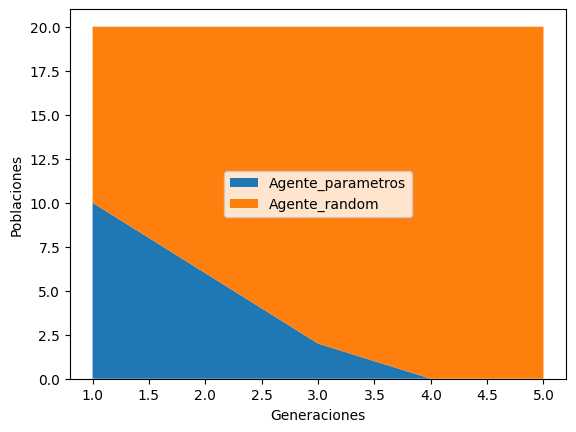

In [191]:
lista_jugadores = [agente_parametros_random, agente_random]

torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=5, error=0.01, polacion_inicial=20, n_rondas=30, reprodctividad=0.2)
torneo_evolutivo.simular()
torneo_evolutivo.dibujar_resultados()

Como se puede ver, hemos conseguido generar una estrategia reactiva, que además se puede ajustar a estrategias como TFT, pero por ahora no lo hace del todo bien:

-1 * C op en la última ronda + 1 * D op en la última ronda - 0.1 -> Esto es TFT parametrizado.

Sin embargo, no obtiene buenos resultados al enfrentarse a estrategias conocidas.


Ahora vamos a modificar el torneo generativo para tratar de generar una serie de parámetros óptimos para jugar a este juego. En concreto, modificaremos la parte en la que se extinguen y se reproducen los agentes, añadiendo los siguientes conceptos:

- Reproducción: Se combinan los parámetros de agentes exitosos para generar nuevos agentes.
- Mutación: Los agentes nuevos pueden presentar diferencias aleatorias respecto a sus progenitores.
- Supervivencia del más fuerte: Los agentes que mejor lo hagan son preservados sin mutaciones.
- Extinción: Igual que como se implementaba anteriormente.



In [192]:
class Poblacion:
    def __init__(self, poblacion_inicial):
        self.dic_poblacion = {Agente_parametros(generar_parametros_random(9)):0.0 for _ in range(poblacion_inicial)}

    @property
    def lista_poblacion(self):
        return list(self.dic_poblacion.keys())

    def ordenar_dic_poblacion(self):
        self.dic_poblacion = dict(sorted(self.dic_poblacion.items(), key=lambda tup: tup[1], reverse=True))

    def eliminar_n_peores(self, n):
        for i in range(n):
            self.dic_poblacion.popitem()

    def reproducir_n_mejores(self, n, p_mutacion = 0.2):
        """Aquí es donde se concentran la mayoría de los cambios respecto de un torneo evolutivo al uso, a continuacion describimos como hemos implementado las ideas anteriores para conseguir que los agentes evolucionen."""
        def mutar_agente(agente:Agente_parametros):
            #Provoca cambios aleatorios en los parametros del agente, con una probabilidad por cada parametro.
            for i in range(len(agente.parametros)):
                if random.random() < p_mutacion:
                    agente.parametros[i] = uniform(-1, 1)
    
                    
        agentes_poblacion = list(self.dic_poblacion.keys())
        mejores_poblacion = agentes_poblacion[:n]
        
        hijos = []
        
        for i in range(n):
            padre_a = random.choice(mejores_poblacion)
            padre_b = random.choice(mejores_poblacion)
            
            #Los parametros de combinan cogiendo una parte de cada unos de los padres siendo el punto de corte un parametro aleatorio.
            punto_corte = randrange(0,9) 
            
            parametros_hijo = padre_a.parametros[0:punto_corte] + padre_b.parametros[punto_corte:]
            
            hijos.append(Agente_parametros(parametros_hijo))
            
        for hijo in hijos:
            mutar_agente(hijo)
            self.dic_poblacion[hijo] = 0.0
        

    def gestionar_evolucion(self, repr_int):
        self.eliminar_n_peores(repr_int)
        self.reproducir_n_mejores(repr_int)
        


In [193]:
class Evolucionar:
    """Muy similar a un torneo evolutivo lo unico que se le modifica el modo en el que imprime para poder ir viendo como evolucionan los parametros y fijarte si estas consiguiendo convergencia o simplemente va cambiando de forma aparentemente aleatoria el que lo hace mejor en cada generacion. Además, si añade una funcionalidad para poder sacar el agente que mejor lo hace al final del proceso."""

    def __init__(self, n_rondas: int = 100,
                       error: float = 0.0,
                       probabilidad_de_finalizar: float = 0.0,
                       generaciones: int = 100,
                       repeticiones: int = 1,
                       reprodctividad: float = 0.05,
                       poblacion_inicial: int = 100,
                       dilema = Dilema(2, -1, 3, 0)):

        self.n_rondas = n_rondas
        self.error = error
        self.probabilidad_de_finalizar = probabilidad_de_finalizar
        self.repeticiones = repeticiones
        self.generaciones = generaciones
        self.reproductividad = reprodctividad
        self.dilema = dilema
        self.poblacion_inicial = poblacion_inicial
        self.poblacion = Poblacion(self.poblacion_inicial)
        self.repr_int = int(self.poblacion_inicial * self.reproductividad)


    def simular(self, imprimir = False):
        for generacion in range(self.generaciones):
            torneo_iterado = Torneo(self.poblacion.lista_poblacion, self.n_rondas, self.probabilidad_de_finalizar,self.error, self.repeticiones, self.dilema)
            torneo_iterado.simular_torneo()

            self.poblacion.dic_poblacion = torneo_iterado.ranking
            self.poblacion.ordenar_dic_poblacion()

            if imprimir:
                print(f"Generacion {generacion}: Poblacion: {self.poblacion.lista_poblacion[0].parametros}")

            self.poblacion.gestionar_evolucion(self.repr_int)
            
    def top_parametros(self, n):

        return  [agente.parametros for agente in self.poblacion.lista_poblacion[:n]]
            


In [216]:
evolucionar = Evolucionar(generaciones=100, poblacion_inicial=30, reprodctividad=0.2, n_rondas=15, error=0.01)
evolucionar.simular()

In [217]:
parametros_evolucionados = evolucionar.poblacion.lista_poblacion[0].parametros

In [218]:
print(parametros_evolucionados)

[0.2297045800174251, -0.8606450736823605, -0.6287067559570461, -0.7627264245149445, -0.8271571502893809, 0.2888498537432933, 0.8922687854701166, 0.3838345684972515, 0.5196430856283625]


Una vez encontrados unos parámetros que, en teoría, son buenos, procedemos a hacer algunas pruebas para ver cómo se comporta el agente.

In [223]:
agente_evolucionado = Agente_parametros(parametros_evolucionados, dp)
agente_evolucionado.nombre = "Evolucionado"
agente_parametros_random_1 = Agente_parametros(generar_parametros_random(9), dp)
agente_parametros_random_1.nombre = "Aleatorio_1"


lista_jugadores = [agente_evolucionado, agente_parametros_random_1]

In [224]:
partida = Partida(dp, agente_evolucionado, agente_random, n_rondas=30)
partida.simular_partida()
print(partida.resultados_partida)

(3)D | C(-1)
(-1)C | D(3)
(3)D | C(-1)
(-1)C | D(3)
(3)D | C(-1)
(-1)C | D(3)
(2)C | C(2)
(-1)C | D(3)
(2)C | C(2)
(-1)C | D(3)
(0)D | D(0)
(0)D | D(0)
(0)D | D(0)
(3)D | C(-1)
(-1)C | D(3)
(3)D | C(-1)
(-1)C | D(3)
(0)D | D(0)
(3)D | C(-1)
(2)C | C(2)
(-1)C | D(3)
(3)D | C(-1)
(-1)C | D(3)
(3)D | C(-1)
(-1)C | D(3)
(0)D | D(0)
(0)D | D(0)
(3)D | C(-1)
(2)C | C(2)
(-1)C | D(3)
Total: 24 | 32



Generacion 0: Poblacion: {'Evolucionado': 20, 'Aleatorio_1': 20}
Generacion 1: Poblacion: {'Evolucionado': 22, 'Aleatorio_1': 18}
Generacion 2: Poblacion: {'Evolucionado': 27, 'Aleatorio_1': 13}
Generacion 3: Poblacion: {'Evolucionado': 35, 'Aleatorio_1': 5}
Generacion 4: Poblacion: {'Evolucionado': 40, 'Aleatorio_1': 0}


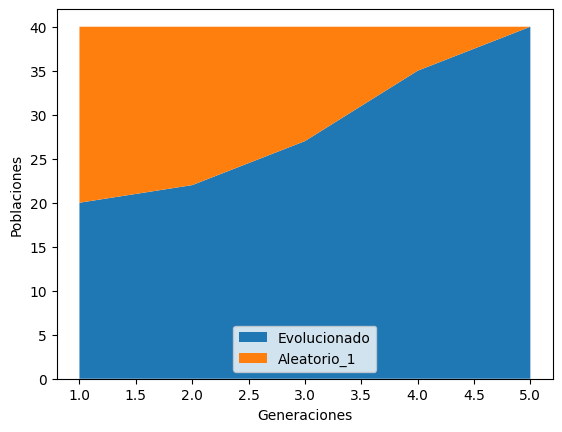

In [226]:
torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=5, error=0.01, polacion_inicial=40, n_rondas=30, reprodctividad=0.2)
torneo_evolutivo.simular(imprimir=True)
torneo_evolutivo.dibujar_resultados()

Este punto parece muy prometedor, ya que efectivamente hemos conseguido generar automáticamente estrategias que se comportan bien contra estrategias aleatorias basadas en parámetros (con las que ha entrenado). Veamos qué sucede cuando las sacamos de su terreno y las enfrentamos contra estrategias que **NO** están basadas en parámetros.


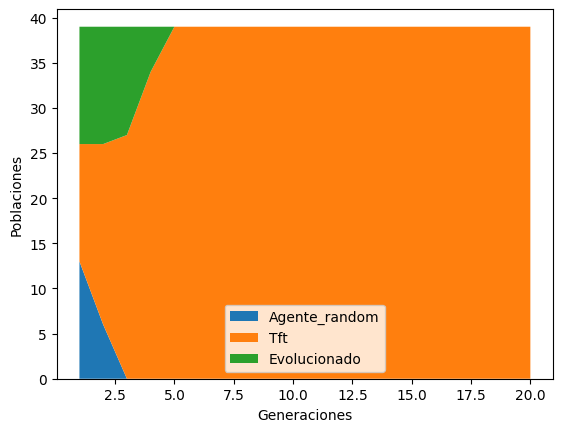

In [228]:
lista_jugadores = [agente_random, tft, agente_evolucionado]

torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=20, error=0.01, polacion_inicial=40, n_rondas=30, reprodctividad=0.2)
torneo_evolutivo.simular()
torneo_evolutivo.dibujar_resultados()


Por desgracia, somos humillados por estrategias que no están basadas en parámetros, como TFT, aunque es mejor que hacerlo al azar. En este punto, abandonamos esta idea, aunque creemos que, seguramente, se puedan obtener resultados óptimos. Aquí van algunas ideas para mejorar los resultados que hemos obtenido:

- Ajustar hiperparámetros: llevar a cabo más experimentos variando las generaciones, la probabilidad de mutación, el número de rondas y otros valores que puedan afectar al resultado.
- Incluir estrategias conocidas en el proceso de evolución: De este modo, en cada generación se seleccionarán no solo los que mejor lo hagan contra estrategias basadas en parámetros, sino que también influirá lo bien que lo hagan contra estrategias que no lo están.

Durante el desarrollo anterior, se nos ocurrió otro método para generar decisiones basadas en parámetros, que tal vez funcione mejor y más rápido durante el proceso de evolución. A continuación lo describimos, lo implementamos y después comparamos los resultados.


## Agente_memoria

La idea de esta estrategia es que podemos fijarnos en las *p* últimas jugadas del oponente y, en base a estas, el programa puede tener aprendida una respuesta. Este proceso se puede optimizar mucho más de lo que pueda parecer, y por eso hemos pensado que esta **memoria** podría comportarse mejor con el proceso evolutivo. A continuación, describimos mejor la idea.

1. Las últimas 4 jugadas del oponente tendrán esta forma: [b1, b2, b3, b4]. Esta lista identifica de forma única las últimas 4 acciones del rival.
2. Por cómo está formateada esta lista, se puede interpretar como un valor expresado en binario, que convertiremos a decimal y que, nuevamente, identificará de forma única las últimas acciones del rival.
3. Por último, nuestra idea es definir una lista con $2^{p}$ parámetros, de modo que *lista[numero_decimal_historial]* almacene un 0 (que se interpretará como cooperación) o un 1 (que se interpretará como deserción).

Esta lista con valores binarios es la que vamos a hacer evolucionar, de modo que obtendremos una forma de actuar basada en las últimas 4 decisiones del oponente.


In [18]:
from dpi import *
import random

dp = Dilema(2, -1, 3, 0)

def generar_memoria_random(n):
    return [random.choice((0,1)) for _ in range(n)]

class Agente_memoria(Agente):
    """Implementamos el agente tal y como lo definimos arriba e implementamos dos metodos para visualizar que decisiones toma el agente de una forma mas visual, como diccionario en vez de como lista."""
    def __init__(self, parametro_memoria: list, dilema: Dilema = dp):
        super().__init__(dilema)
        self.parametro_memoria = parametro_memoria

    def diccionario_decisiones(self):

        diccionario = {}

        for i in range(16):
            diccionario[f"{int(bin(i)[2:]):04d}"] = self.parametro_memoria[i]

        return diccionario

    def diccionario_decisiones_formateado(self):

        diccionario = {}

        for i in range(16):
            clave = f"{int(bin(i)[2:]):04d}"
            clave = clave.replace("0","C")
            clave = clave.replace("1","D")

            bin_to_str = {
                0:"C",
                1:"D"
            }

            valor = bin_to_str[self.parametro_memoria[i]]

            diccionario[clave] = valor

        return diccionario

    def __str__(self):
        return f"Agente con parametro de memoria: {"".join([str(x) for x in self.parametro_memoria])}"

    def __repr__(self):
        return str(self)

    def generar_decision(self):
        """Durante las 4 primeras rondas empieza cooperando y la probabilidad cooperar se basa en lo que haya cooperado el oponente, de modo que acepta cadenas de cooperacion si no hay error"""
        if len(self.resultados_partida) == 1:
            return 0
        elif rondas := len(self.resultados_partida) <= 3:
            prob_cooperar = (rondas - sum(self.resultados_partida.lista_jugadas_a2)) / rondas

            if random.random() < prob_cooperar:
                return 0
            else:
                return 1
        else:
            indice = int("".join([str(x) for x in self.resultados_partida.lista_jugadas_a2[-4:]]), 2)
            return self.parametro_memoria[indice]


"""A continuacion los cambios son minimos resecto a la ultima definicion de estas clases"""


class Poblacion:
    def __init__(self, poblacion_inicial):
        self.dic_poblacion = {Agente_memoria(generar_memoria_random(16), dp): 0.0 for _ in range(poblacion_inicial)}

    @property
    def lista_poblacion(self):
        return list(self.dic_poblacion.keys())

    def ordenar_dic_poblacion(self):
        self.dic_poblacion = dict(sorted(self.dic_poblacion.items(), key=lambda tup: tup[1], reverse=True))

    def eliminar_n_peores(self, n):
        for i in range(n):
            self.dic_poblacion.popitem()

    def reproducir_n_mejores(self, n, p_mutacion=0.2):
        def mutar_agente(agente: Agente_memoria):
            for i in range(len(agente.parametro_memoria)):
                if random.random() < p_mutacion:
                    agente.parametro_memoria[i] = int(not bool(agente.parametro_memoria[i]))

        agentes_poblacion = list(self.dic_poblacion.keys())
        mejores_poblacion = agentes_poblacion[:n]

        hijos = []

        for i in range(n):
            padre_a = random.choice(mejores_poblacion)
            padre_b = random.choice(mejores_poblacion)

            punto_corte = randrange(0, 16)

            parametros_hijo = padre_a.parametro_memoria[0:punto_corte] + padre_b.parametro_memoria[punto_corte:]

            hijos.append(Agente_memoria(parametros_hijo))

        for hijo in hijos:
            mutar_agente(hijo)
            self.dic_poblacion[hijo] = 0.0

    def gestionar_evolucion(self, repr_int):
        # Mejorar la gestion de los casos de empate
        self.eliminar_n_peores(repr_int)
        self.reproducir_n_mejores(repr_int)


class Evolucionar:

    def __init__(self, n_rondas: int = 100,
                 error: float = 0.0,
                 probabilidad_de_finalizar: float = 0.0,
                 generaciones: int = 100,
                 repeticiones: int = 1,
                 reprodctividad: float = 0.05,
                 poblacion_inicial: int = 100,
                 dilema=Dilema(2, -1, 3, 0)):

        self.n_rondas = n_rondas
        self.error = error
        self.probabilidad_de_finalizar = probabilidad_de_finalizar
        self.repeticiones = repeticiones
        self.generaciones = generaciones
        self.reproductividad = reprodctividad
        self.dilema = dilema
        self.poblacion_inicial = poblacion_inicial
        self.poblacion = Poblacion(self.poblacion_inicial)
        self.repr_int = int(self.poblacion_inicial * self.reproductividad)

    # Hay que gestionar los casos de empates
    def simular(self, imprimir=False):
        for generacion in range(self.generaciones):
            torneo_iterado = Torneo(self.poblacion.lista_poblacion, self.n_rondas, self.probabilidad_de_finalizar,
                                    self.error, self.repeticiones, self.dilema)
            torneo_iterado.simular_torneo()

            self.poblacion.dic_poblacion = torneo_iterado.ranking
            self.poblacion.ordenar_dic_poblacion()

            if imprimir:
                print(f"Generacion {generacion}: Poblacion: {self.poblacion.lista_poblacion[0].parametro_memoria}")
                # print(self.poblacion.dic_poblacion.values())

            self.poblacion.gestionar_evolucion(self.repr_int)

    def top_parametros(self, n):

        return [agente.parametro_memoria for agente in self.poblacion.lista_poblacion[:n]]

In [79]:
evolucionar = Evolucionar(generaciones=1000, poblacion_inicial=30, reprodctividad=0.2, n_rondas=15, error=0.01)
evolucionar.simular(imprimir=True)

Generacion 0: Poblacion: [1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0]
Generacion 1: Poblacion: [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
Generacion 2: Poblacion: [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1]
Generacion 3: Poblacion: [0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Generacion 4: Poblacion: [0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0]
Generacion 5: Poblacion: [0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]
Generacion 6: Poblacion: [0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Generacion 7: Poblacion: [0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1]
Generacion 8: Poblacion: [0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Generacion 9: Poblacion: [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1]
Generacion 10: Poblacion: [0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1]
Generacion 11: Poblacion: [0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0]
Generacion 12: Poblacion: [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1]
Generacion 13: Poblacion: [0, 1, 1,

In [97]:
agente_memoria_evolucionado = evolucionar.poblacion.lista_poblacion[0]

In [99]:
agente_memoria_evolucionado.diccionario_decisiones_formateado().items()

dict_items([('CCCC', 'C'), ('CCCD', 'C'), ('CCDC', 'D'), ('CCDD', 'D'), ('CDCC', 'C'), ('CDCD', 'C'), ('CDDC', 'C'), ('CDDD', 'D'), ('DCCC', 'D'), ('DCCD', 'C'), ('DCDC', 'C'), ('DCDD', 'D'), ('DDCC', 'C'), ('DDCD', 'D'), ('DDDC', 'D'), ('DDDD', 'D')])

Surgen comportamientos aparentemente lógicos como:

- ('CCCC', 'C'): Acepta cadenas de cooperación, incluidas las que plantea él mismo.
- ('CCCD', 'C'): No permite que las cadenas se rompan por error.
- ('CCDD', 'D') y ('DDDD', 'D'): Sin embargo, reacciona desconfiando ante comportamientos hostiles.
- ('CCDC', 'D'): También hay casos en los que traiciona, como este, en el que parece que ha aprendido que el rival quiere seguir confiando, pero castiga las deserciones puntuales.


Ya tenemos un agente con los parámetros ajustados, y durante el proceso se puede apreciar una convergencia de forma mucho más clara, lo cual es una buena señal. Vamos a hacer algunas pruebas con este agente.


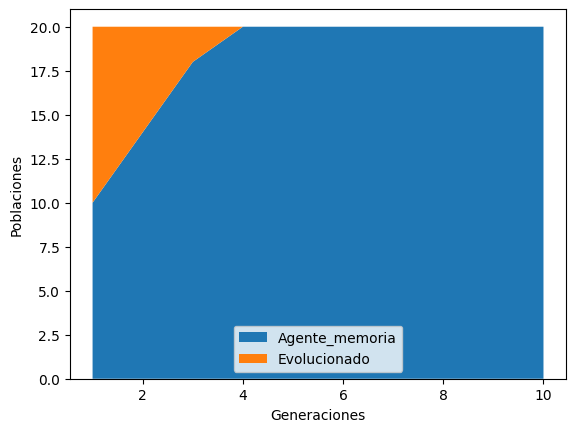

In [161]:
lista_jugadores = [agente_memoria_evolucionado, agente_evolucionado]

torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=10, error=0.01, polacion_inicial=20, n_rondas=100,
                                    reprodctividad=0.2)
torneo_evolutivo.simular()
torneo_evolutivo.dibujar_resultados()

Vemos que, de los dos intentos que hemos hecho para crear agentes evolucionados, esta última implementación es la mejor. Ahora la comparamos con otras estrategias con las que no se ha enfrentado durante el entrenamiento, para así ver si generaliza correctamente.


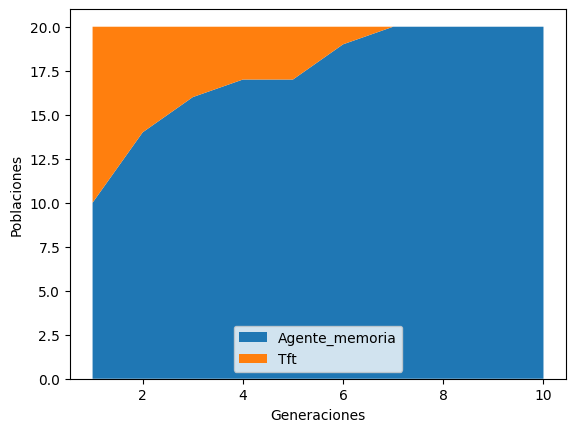

In [162]:
lista_jugadores = [agente_memoria_evolucionado, tft]

torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=10, error=0.01, polacion_inicial=20, n_rondas=100, reprodctividad=0.2)
torneo_evolutivo.simular()
torneo_evolutivo.dibujar_resultados()

Parece que la estrategia no esta generalizando mal, puesto que es el primer agente que conseguimos que gane a TFT.

In [157]:
#Importamos y modificamos la estrategia del profesor para que coicida con nuestra sintaxis, y hacemos las ultimas pruebas.
class Destructomatic(Agente):
    """
    Dude, I'll explain it to you with a poem:

    "Play it nice, keep it fair,
    But cross me twice, and beware.
    Be too kind, I might deceive,
    In this game, expect the weave."

    """
    def __init__(self, dilema: Dilema = dp):
        super().__init__(dilema)
        self.grudge = 0  # Track grudge level

    def generar_decision(self) -> int:
        """
        Starts cooperating, is forgiving but escalates defection in response to consistent defection by the opponent.
        """
        
        turns = len(self.resultados_partida)

        if turns < 2:
            return 0

        # Forgiving and gathers data in the first few turns
        if turns < 10:
            if self.resultados_partida.lista_jugadas_a2[-2:] != [1, 1]:
                return 0
            else:
                self.grudge += 1
                return 1

        count_D_opponent = self.resultados_partida.lista_jugadas_a2.count(1)  # Count opponent defections
        cooperation_rate = (turns - count_D_opponent) / turns  # Calculate cooperation rate

        # Escalation based on opponent's defection pattern
        if self.resultados_partida.lista_jugadas_a2[-2:] == [1, 1]:
            self.grudge += 1
            if self.grudge >= 3:  # After 3 consecutive defections, escalate with a probabilistic defection
                if random.random() < 0.75:
                    return 1
            return 1
        else:
            self.grudge = max(0, self.grudge - 1)  # Reduce grudge if opponent cooperates

        # Exploit very cooperative opponents with occasional defection
        if cooperation_rate > 0.8 and random.random() < 0.1:
            return 1

        # Generally forgiving strategy with slight randomness
        if count_D_opponent / turns > random.random():
            return 1

        return 0
    
destructomatic = Destructomatic(dilema=dp)

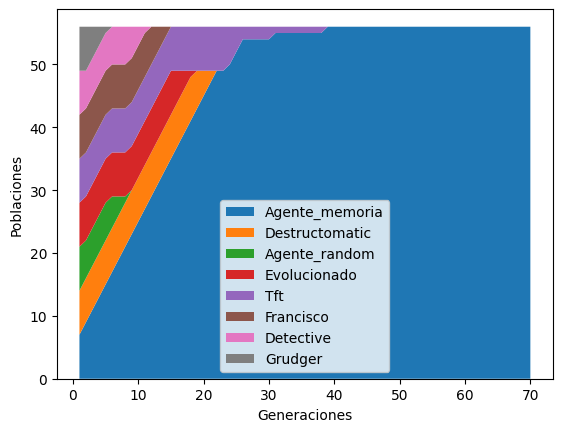

In [229]:
lista_jugadores = [agente_memoria_evolucionado, destructomatic, agente_random, agente_evolucionado, tft, paco, detective, grudger]

torneo_evolutivo = Torneo_evolutivo(lista_jugadores, generaciones=70, error=0.01, polacion_inicial=60, n_rondas=30, reprodctividad=0.05)
torneo_evolutivo.simular()
torneo_evolutivo.dibujar_resultados()

Por ultimo una prueba con mas estrategias tambien la pasa sin problemas por lo que la usaremos en la estrategia final.

Por último, contemplamos de nuevo posibles mejoras que se le podrían aplicar al proyecto:

1. Las mutaciones se están aplicando con la misma probabilidad y de una forma completamente aleatoria. Se podría plantear otro procedimiento que favoreciera la convergencia, en concreto, hacer que la probabilidad de mutación descendiera a medida que avanzan las generaciones y que las mutaciones fueran cada vez menos fuertes.
2. Quizás una solución más óptima se podría conseguir usando tanto las respuestas que hemos obtenido en función de las últimas 4 jugadas como alguna heurística que podríamos definir para aprovechar la información de la partida con más profundidad.
